## Test Richardson Lucy Gradient Consensus 

In this notebook we test Richardson Lucy with Gradient Consensus stopping criteria with a simple 2D simulation of a sphere.

To make things interesting we add the option of moving the sphere to the edge of the image, such that half the sphere is outside the image!

## Dependencies

To run this code you need a scientific python environment with the standard stuff (numpy, scikit-image, pyplot, etc.).  Most of this can be installed with pip.  You also need cupy and tnia-python. 

For cupy I find conda is more reliable as it seems to get cuda drivers you need.  I tend not to increment versions until I need to so for my cupy environments I still install ```cudatoolkit=11.8```

```
conda install -c conda-forge cudatoolkit=11.8 cupy==11.5.0
```

You also will need my utility libary

```
pip install git+https://github.com/True-North-Intelligent-Algorithms/tnia-python.git
```

Or grab it from github, navigate to the directory it was downloaded to and install interactively

```
pip install -e .
```

In [1]:
from tnia.deconvolution.forward import forward
from tnia.deconvolution.gaussian_psf import gaussian_2d
import raster_geometry as rg
import numpy as np
from tnia.simulation.phantoms import add_small_to_large_2d
import matplotlib.pyplot as plt
from tnia.plotting.plt_helper import imshow_multi2d, imshow2d

## Create sphere near edge

Create a simple test image with a sphere near the edge

We also add background and a gain.  Try changing sigma, gain and background to see what happens with different SNR and blur levels. 

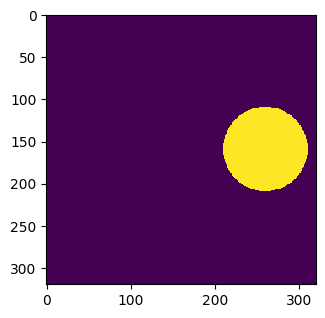

In [2]:
width, height = 320, 320

truth = np.zeros([height, width], dtype=np.float32)

r = 50

situation = 1

if situation == 0:
    # low blur high noise
    sigma = 4.0
    gain = 30
    background = 20 
elif situation == 1:
    # high blur low noise
    sigma = 8.0
    gain = 100
    background = 20
# make a sphere in the middle 

edge_sphere = True

if edge_sphere:
    x, y = 260,160 
else:
    x, y = 160, 160

size = [height//2, width//2]
temp=rg.circle(size, r)
add_small_to_large_2d(truth, temp, x, y, mode='replace_non_zero')
truth = gain * truth + background

fig = imshow2d(truth, width = 8, height = 3.5)

## Now create the PSF

In [3]:
psf = gaussian_2d(65,sigma)

## Apply the forward imaging model

The ```forward``` function should do a fully padded convolution, add noise, then crop back to the image size.  Thus there should be no boundary wrap around after convolution (it's always good practice to check for this when using a convolution function).

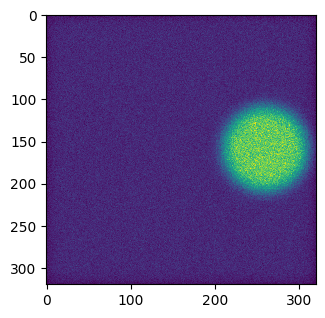

In [4]:
image = forward(truth, psf, 0)

fig = imshow2d(image, width = 8, height = 3.5)

## Crop a little more...

We crop a little more to truncate the sphere so we have a nice test image for understanding edge handling.

(260, 260)


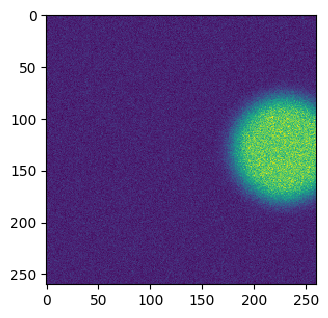

In [5]:
image = image[30:-30,30:-30]
truth = truth[30:-30,30:-30]

print(image.shape)
fig = imshow2d(image, width = 8, height = 3.5)

In [7]:
from tnia.deconvolution.richardson_lucy_gradient_consensus import rlgc

## Perform Gradient Consensus Richardson Lucy

We apply it twice, first time without non-circulant edge handling, and second time with non-circulant edge handling. 

In [8]:
recon, stats, stop_iteration = rlgc(image, psf, 50, False, truth=truth, noncirc=False)
recon_non_circ, stats_non_circ, stop_iteration_non_circ = rlgc(image, psf, 50, False, truth=truth, noncirc=True)

0 10 20 30 40 
0 10 20 30 40 


## Plot RMSE vs Iteration

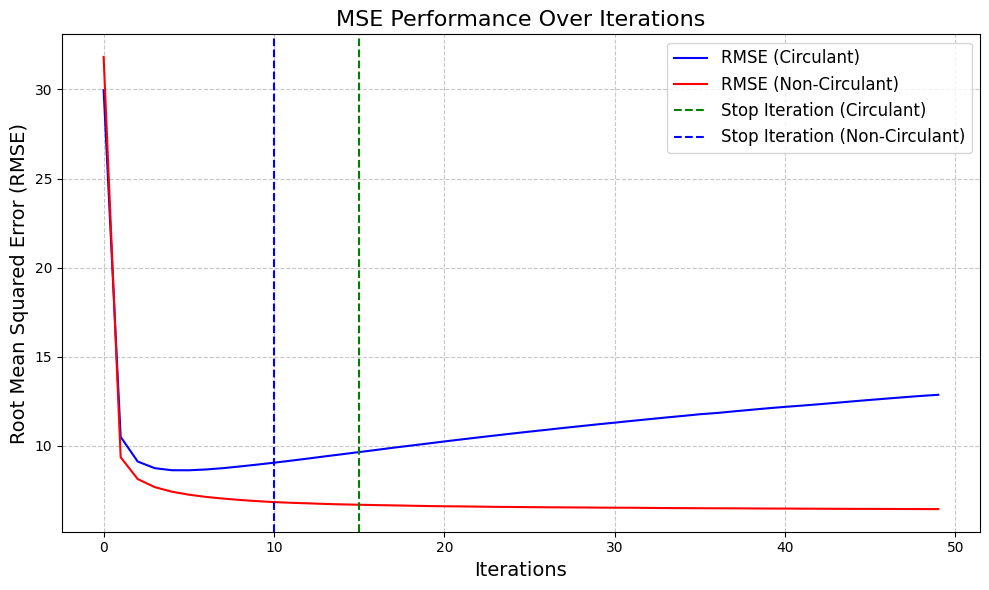

In [9]:
import matplotlib.pyplot as plt

def generate_fig(stats, stats_non_circ, stop_iteration, stop_iteration_non_circ):
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot the data
    ax.plot(stats['rmse'], label='RMSE (Circulant)', color='blue')
    ax.plot(stats_non_circ['rmse'], label='RMSE (Non-Circulant)', color='red')

    # Add vertical lines for stop iterations
    ax.axvline(x=stop_iteration, color='green', linestyle='--', label='Stop Iteration (Circulant)')
    ax.axvline(x=stop_iteration_non_circ, color='blue', linestyle='--', label='Stop Iteration (Non-Circulant)')

    # Add title and axis labels
    ax.set_title("MSE Performance Over Iterations", fontsize=16)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.set_ylabel("Root Mean Squared Error (RMSE)", fontsize=14)

    # Add legend
    ax.legend(fontsize=12)

    # Improve grid visibility
    ax.grid(visible=True, linestyle='--', alpha=0.7)

    # Show the
    plt.tight_layout()

    return fig

fig = generate_fig(stats, stats_non_circ, stop_iteration, stop_iteration_non_circ)

## Take a look at the images

You should see some artifacts in the circulant decon.  Using non-circulant helps the situation.

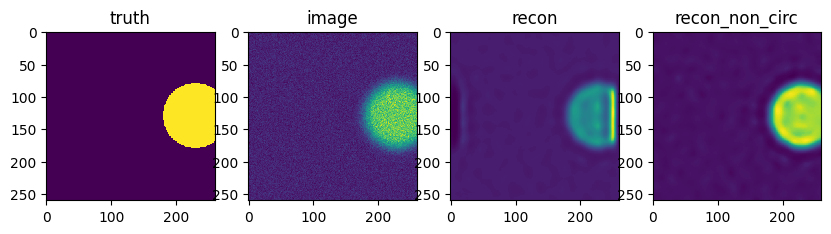

In [10]:
fig = imshow_multi2d([truth, image, recon, recon_non_circ], ['truth', 'image', 'recon', 'recon_non_circ'], 1, 4)

## Run a few times with different seeds

Let's see how much randomness effects the stop iteration...

0 10 20 30 40 
0 10 20 30 40 
0 10 20 30 40 
0 10 20 30 40 
0 10 20 30 40 
0 10 20 30 40 
0 10 20 30 40 
0 10 20 30 40 
0 10 20 30 40 
0 10 20 30 40 


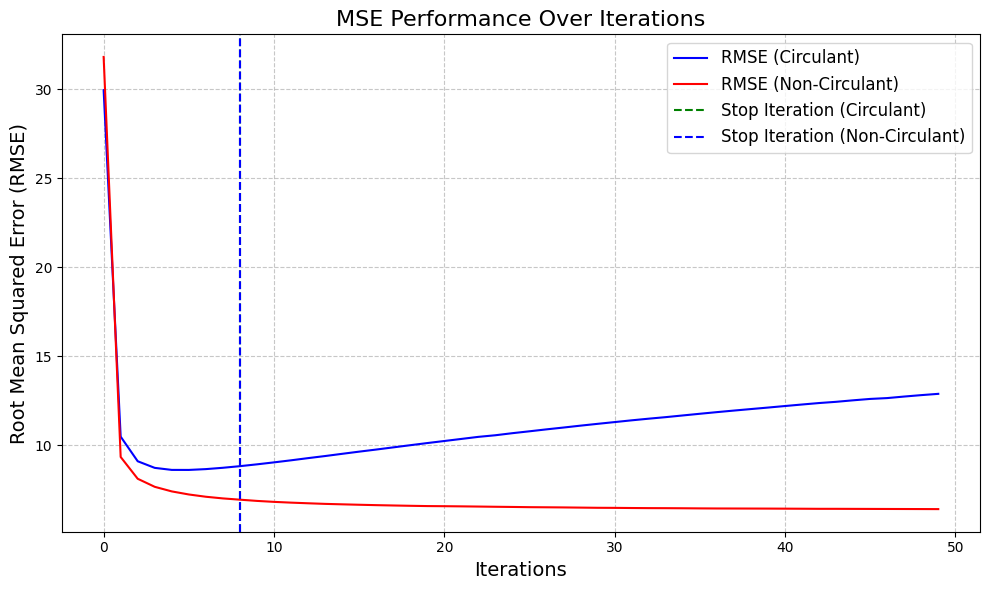

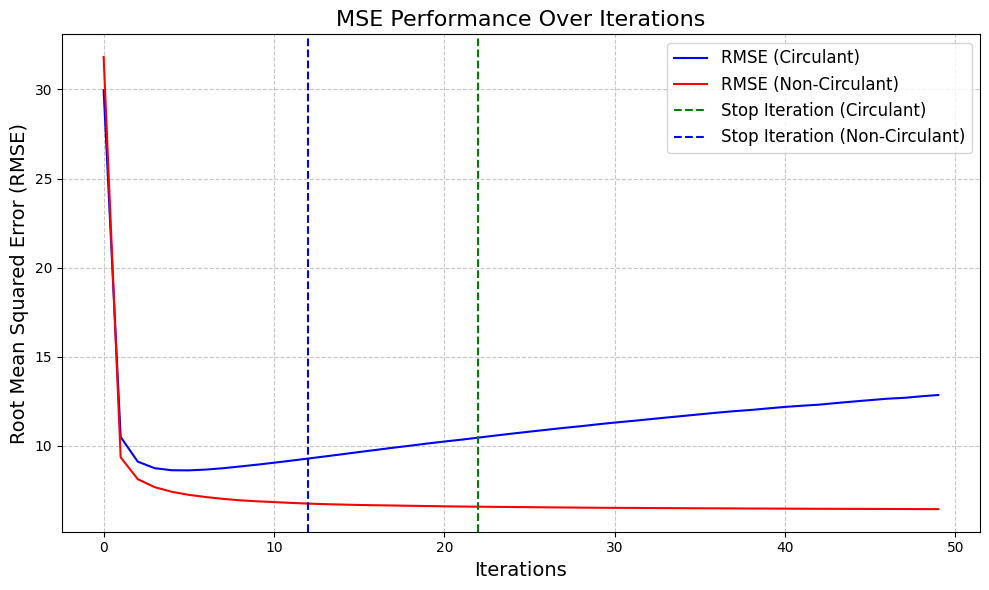

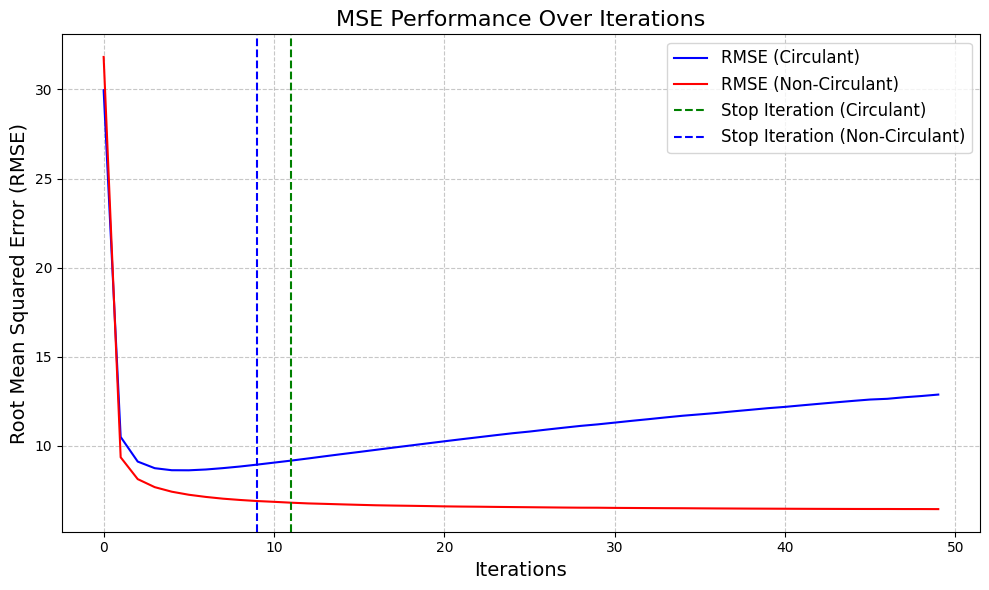

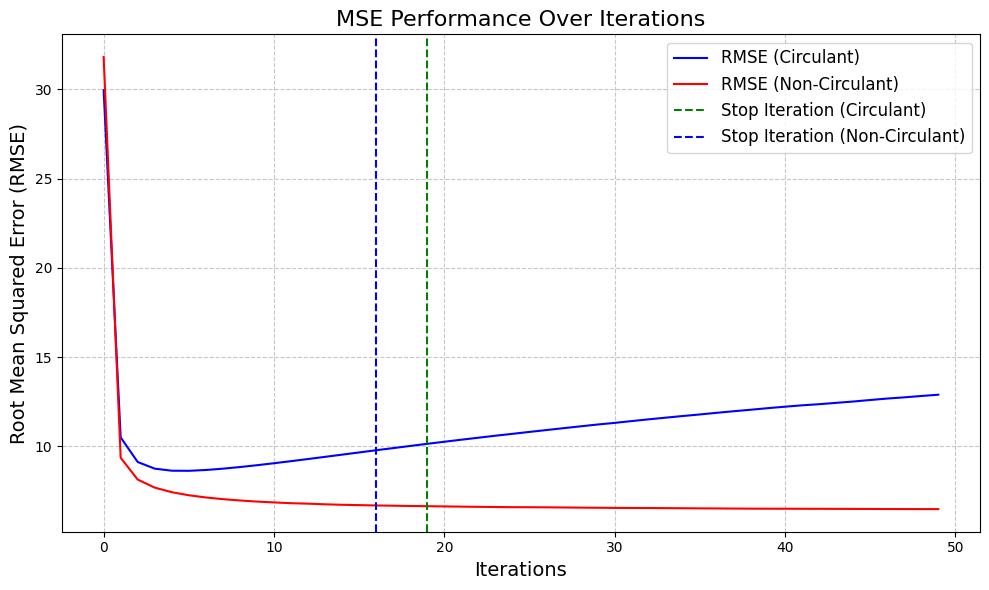

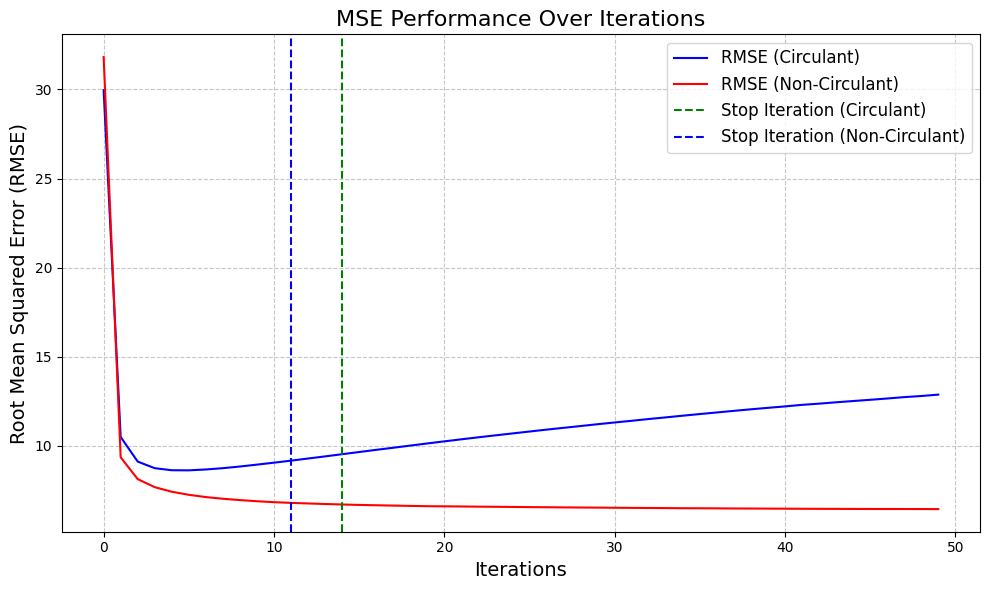

In [11]:
for i in range(5):
    recon, stats, stop_iteration = rlgc(image, psf, 50, False, truth=truth, noncirc=False, seed=i)
    recon_non_circ, stats_non_circ, stop_iteration_non_circ = rlgc(image, psf, 50, False, truth=truth, noncirc=True, seed=i)
    fig = generate_fig(stats, stats_non_circ, stop_iteration, stop_iteration_non_circ)